# CP321 Project - Analysis of Ontario ICU Data through the COVID Pandemic
Jake Watts - 151477490
Evan Parisotto - 

In [33]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning) # supress PyArrow warning from pandas

df = pd.read_csv("data/region_hospital_icu_covid_data.csv")

# Convert to datetime
df["date"] = pd.to_datetime(df["date"])

integer_columns = ['icu_current_covid', 'icu_current_covid_vented', 
               'hospitalizations', 'icu_crci_total', 'icu_crci_total_vented', 
               'icu_former_covid', 'icu_former_covid_vented']

regions = df["oh_region"].unique()

# Convert all numeric types to int64
for column in integer_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce").fillna(0).astype("int64")

## Introduction

[Data Source - COVID-19 Cases in Hospital and ICU by Ontario Health Region](https://data.ontario.ca/dataset/covid-19-cases-in-hospital-and-icu-by-ontario-health-region)

[Key Dates - COVID-19 vaccination in Canada](https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Canada)

### Data Fields

| CSV Field           | Description                                                                                   |
|---------------------|-----------------------------------------------------------------------------------------------|
| `date`              | Date                                                                                          |
| `oh_region`         | Ontario Health Region                                                                                     |
| `hospitalizations`  | Current hospitalizations with COVID-19                                                        |
| `icu_crci_total`    | Current patients in Intensive Care Units (ICUs) due to COVID-related critical illness         |
| `icu_current_covid` | Patients in Intensive Care Units (ICUs) testing positive for COVID                            |
| `icu_former_covid`  | Current patients in Intensive Care Units (ICUs) no longer testing positive for COVID          |
| `icu_crci_total_vented` | Current patients in Intensive Care Units (ICUs) on ventilators due to COVID-related critical illness |
| `icu_current_covid_vented` | Current patients in Intensive Care Units (ICUs) on ventilators testing positive for COVID   |
| `icu_former_covid_vented` | Current patients in Intensive Care Units (ICUs) on ventilators no longer testing positive for COVID |

### Candidate Questions
1. **Hospitalization Time Series with Key Date Markers**
   - **Time Series** showing hospitalizations over time with annotations for key dates. We can tailor the question to the key dates we choose to use.
   - See if it makes sense to decompose the time series.
   - Use `hospitalizations` as the variable. Look up key dates through the range (2020-2024) separately. There's no need to cite here.
   - Important key dates would include the introduction of the vaccines.
   - I'm also interested in the seasonlity of hospitalizations - do they go up or down reliably during certain parts of the year?

2. **Regional Differences in Ventilator Utilization**
   - **Choropleth Map** to visualize ventilator utilization intensity by region.
   - The more populous regions will obviously have more utilization, so maybe we could instead visualize the per-capital ventilator utilization.
   - Find coordinates for the OH regions.
   - Find population data for each of the OH regions through the time range.
  
3. **ECDF of Hospitalizations Through the Pandemic**
   - I'm interested in getting a sense of _when_ during the pandemic most of the people who ended up being hospitalized were hospitalized.

## Motivation

### Question 1: Time Series

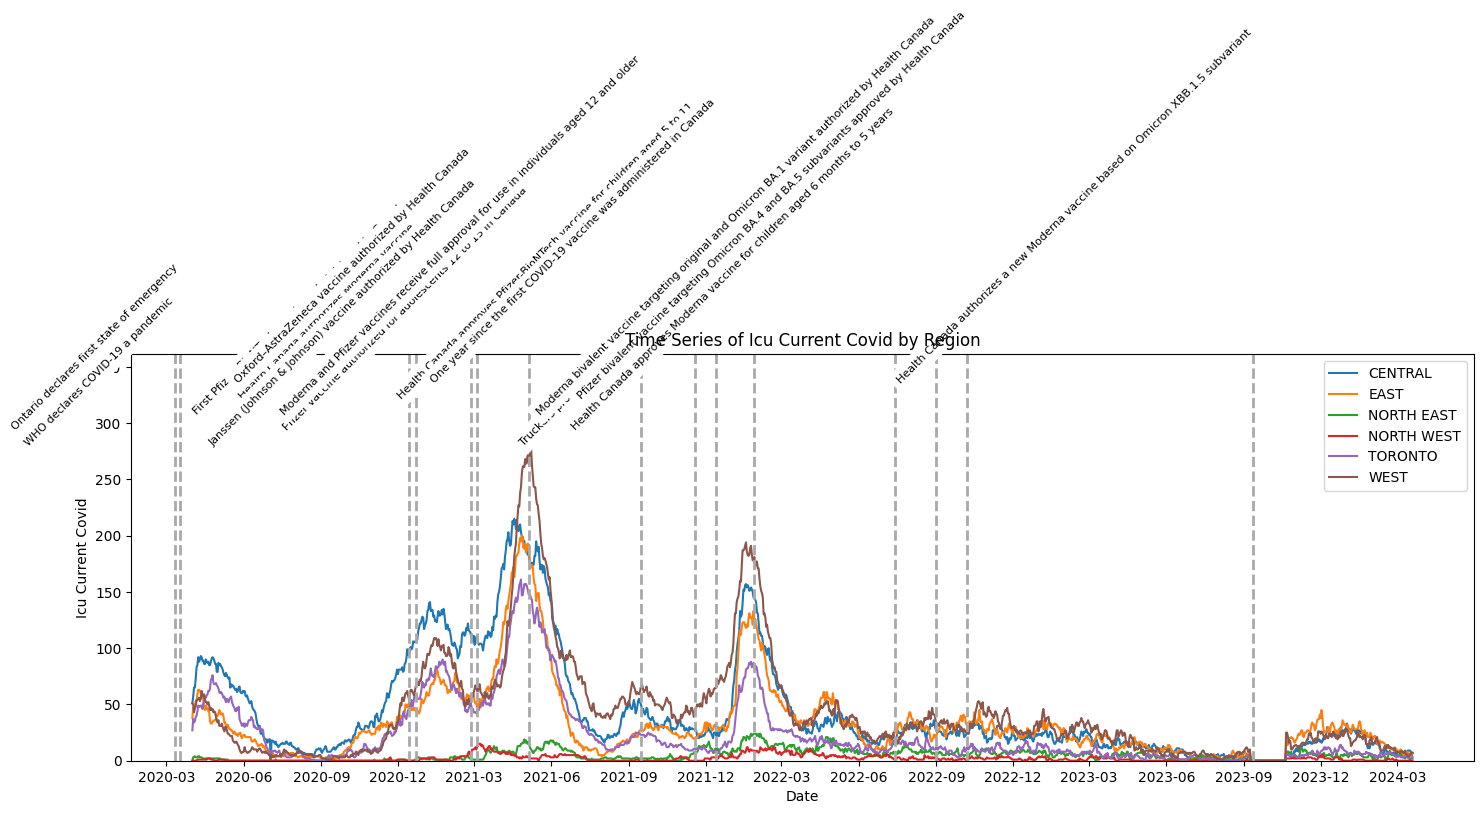

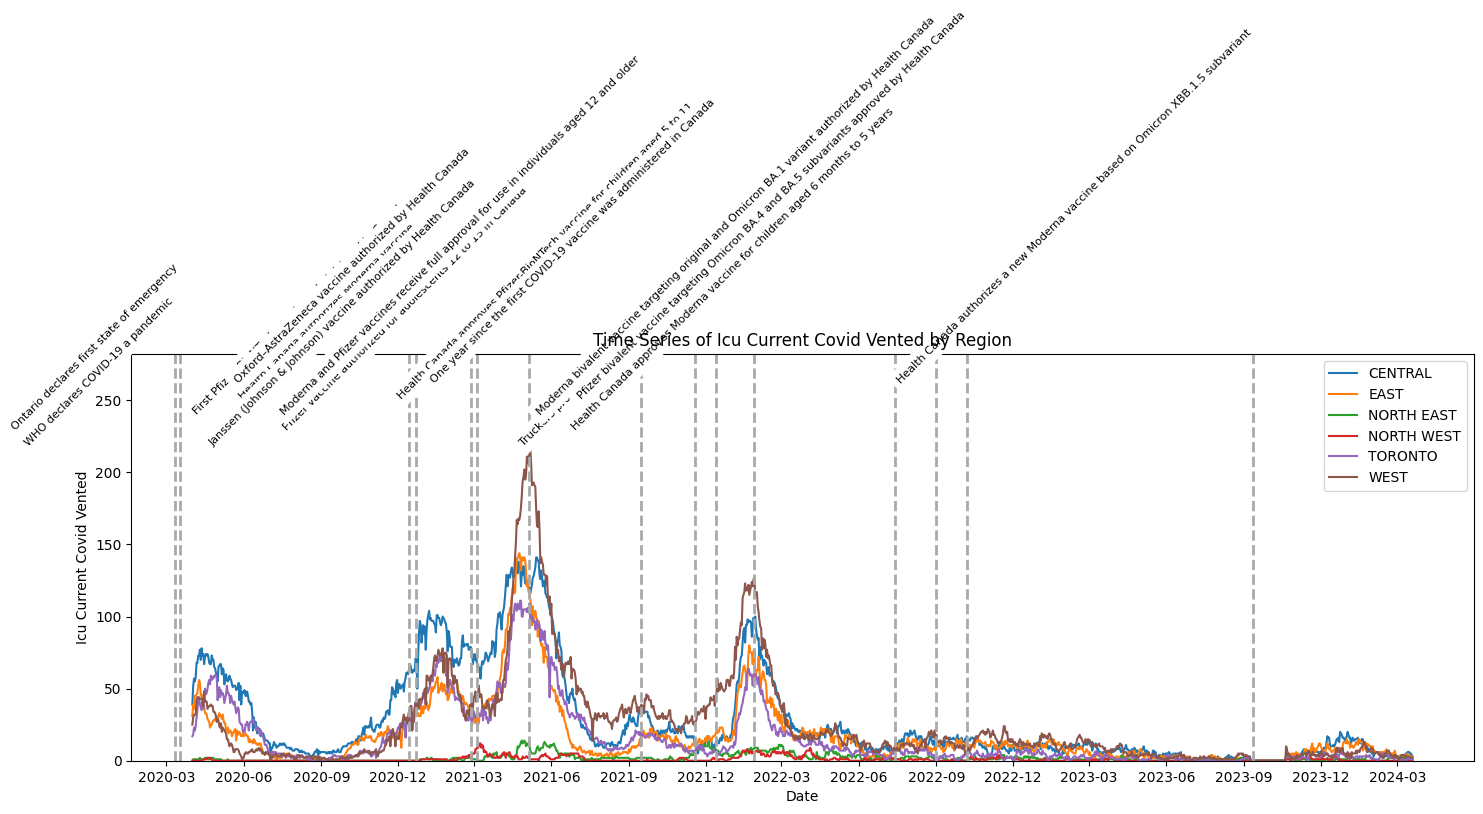

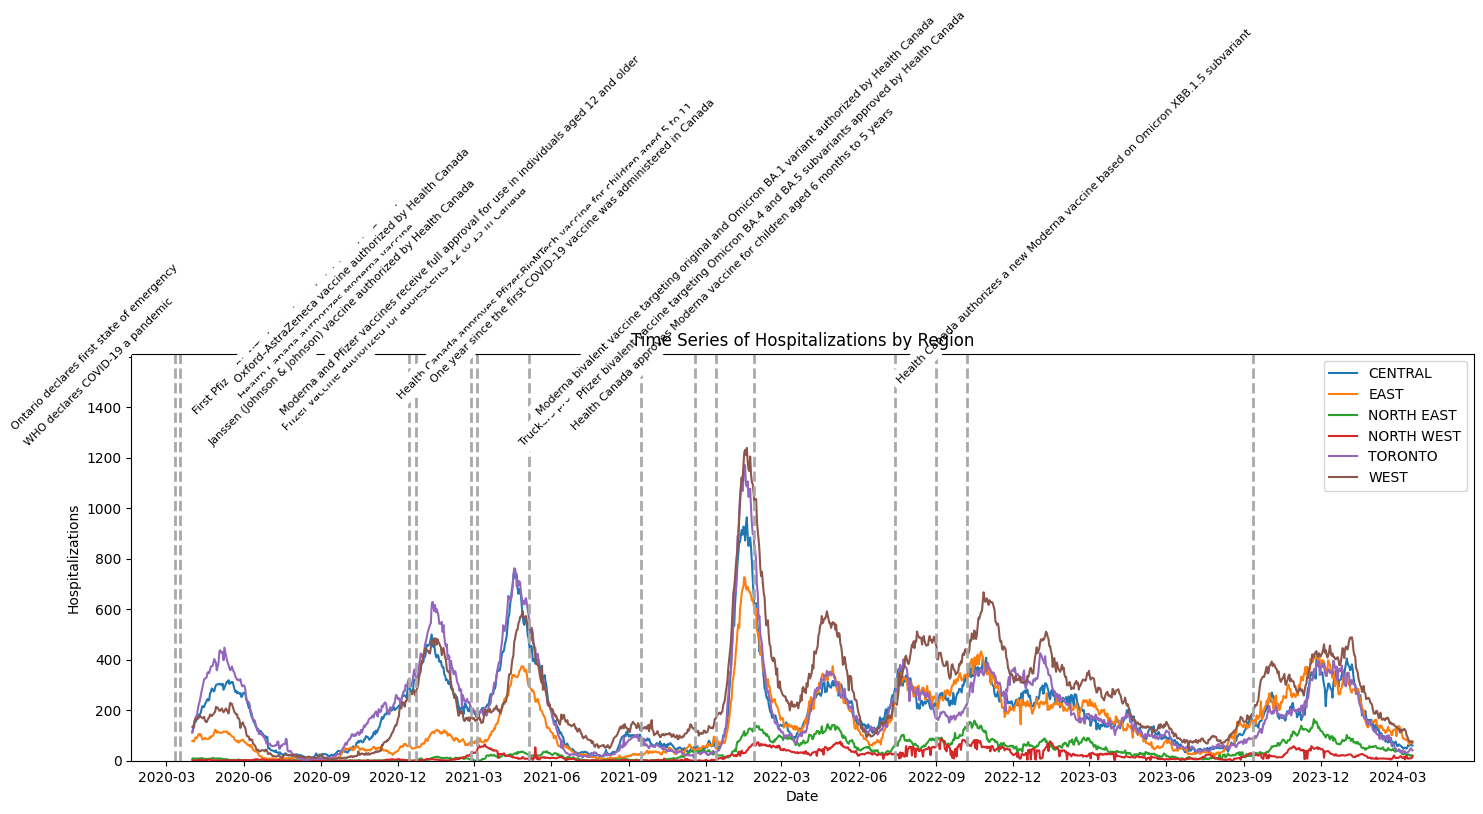

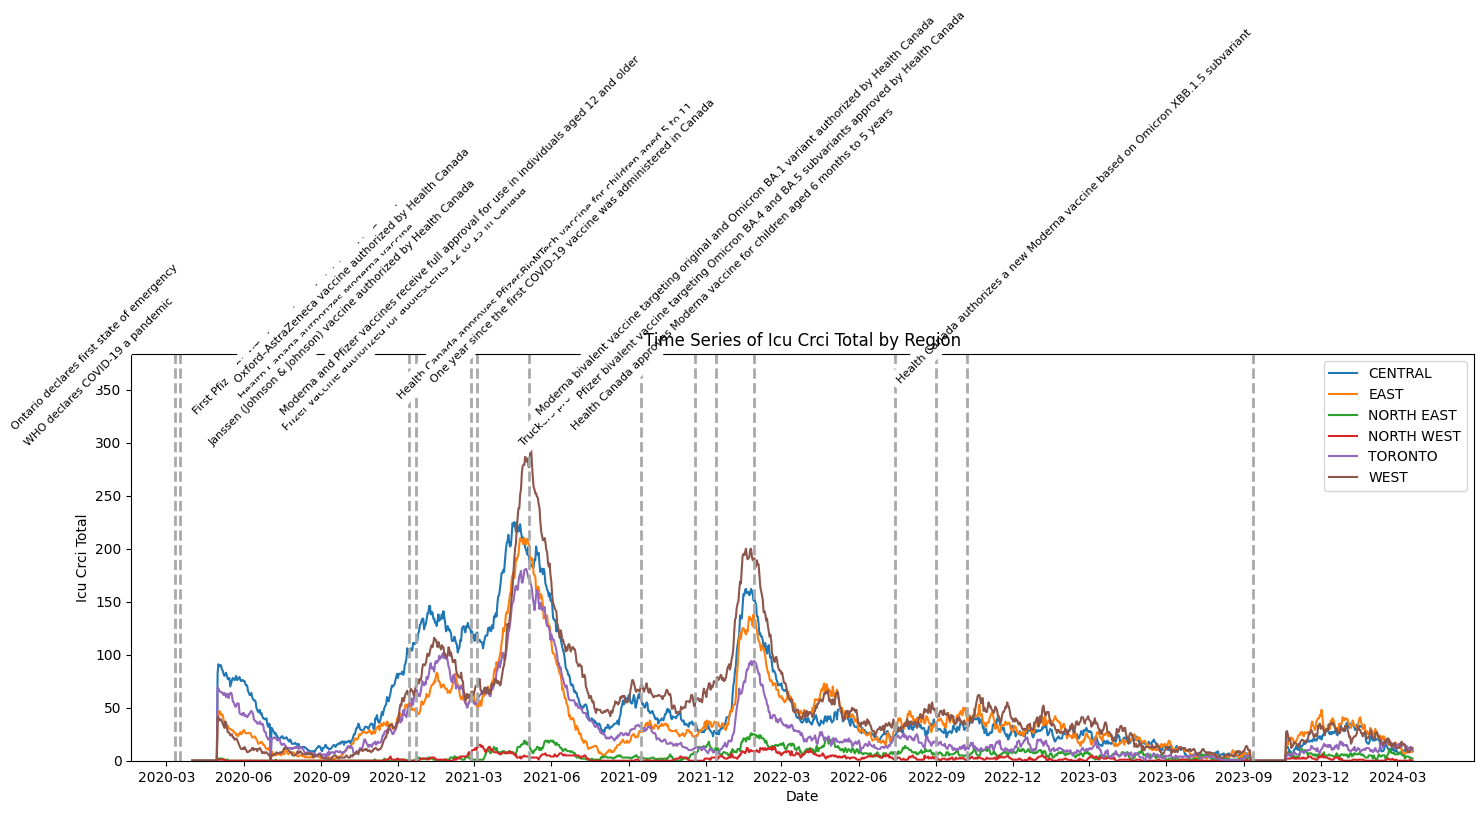

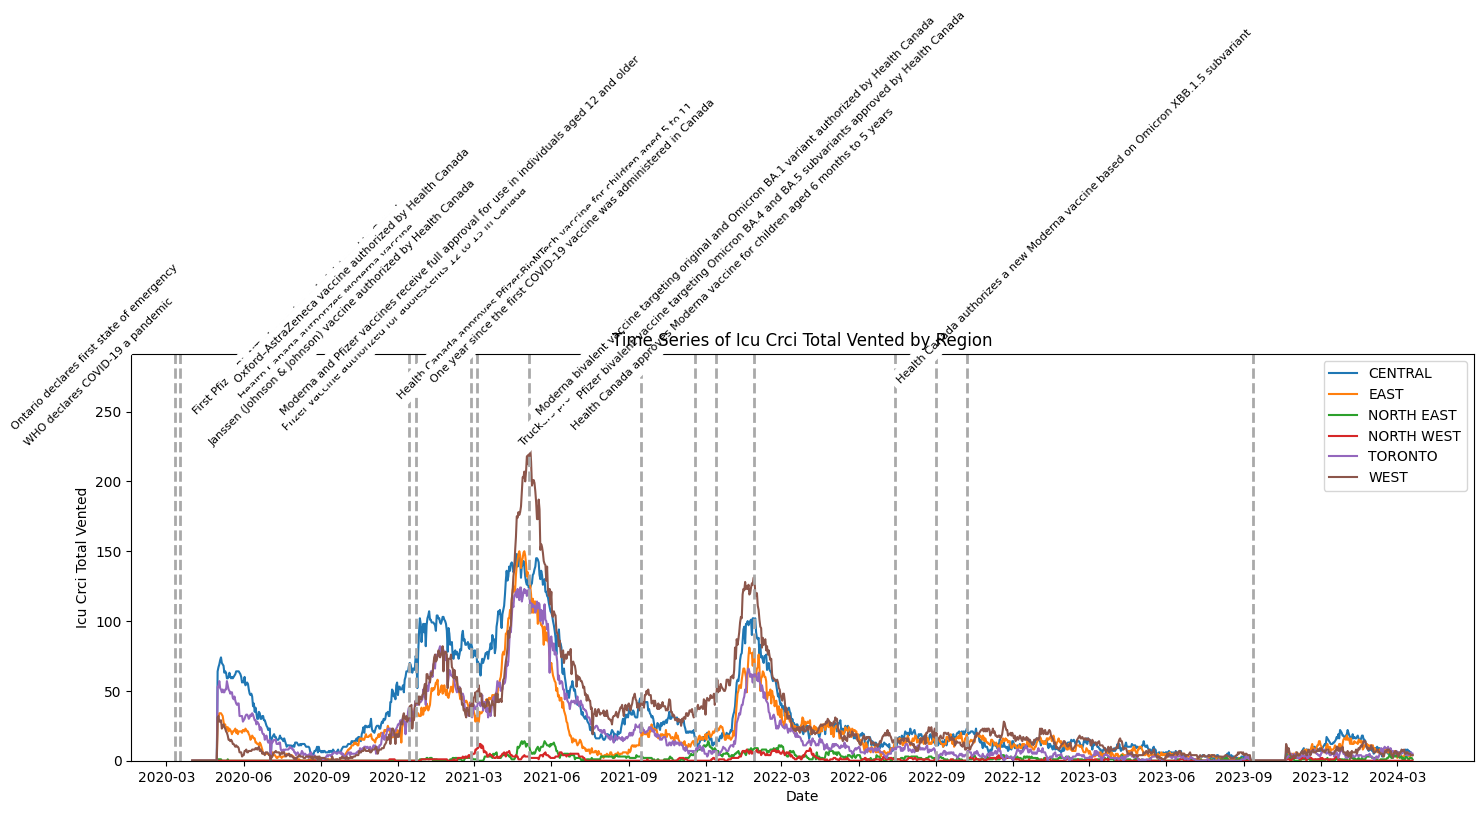

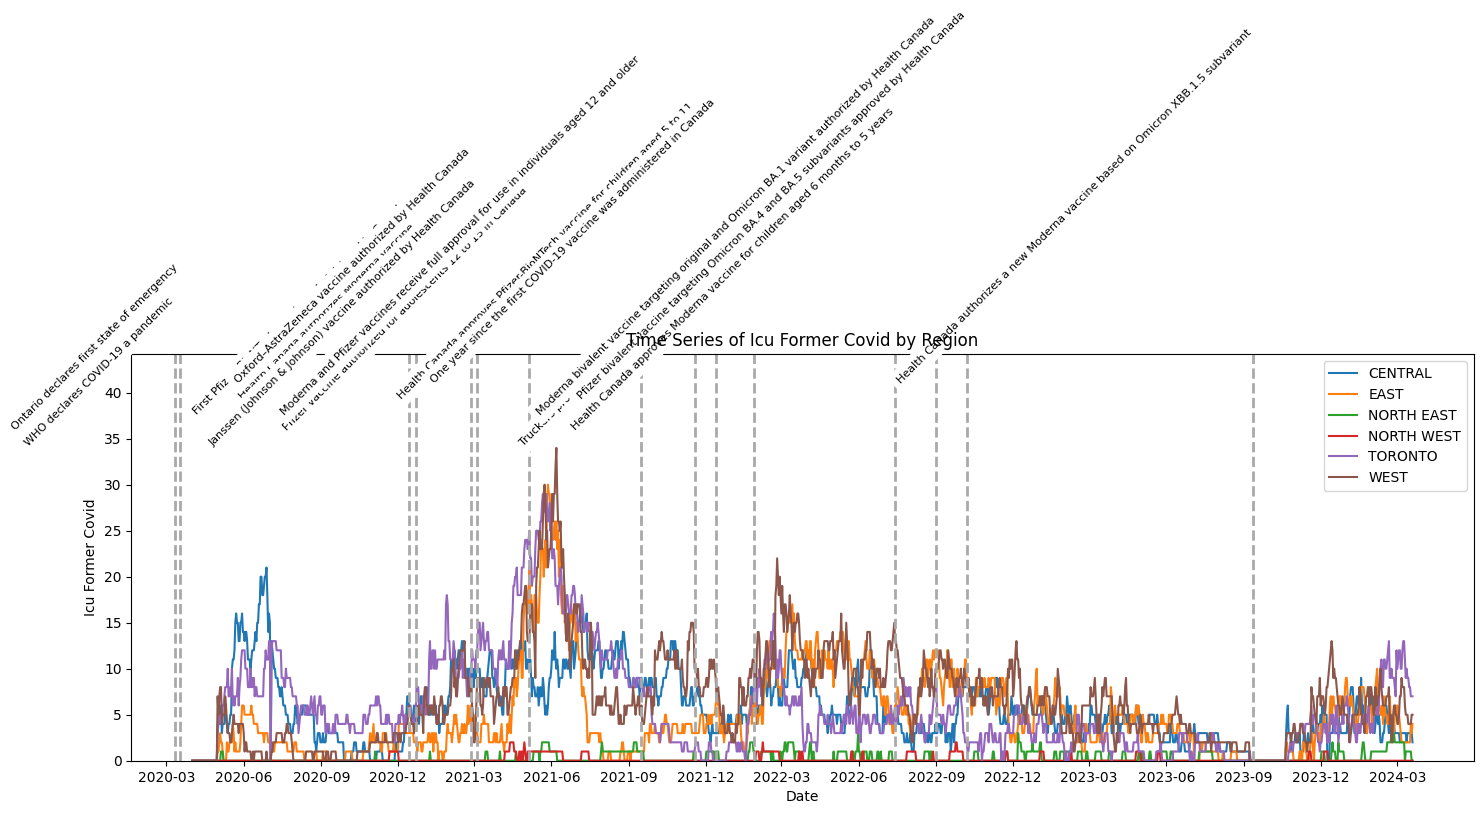

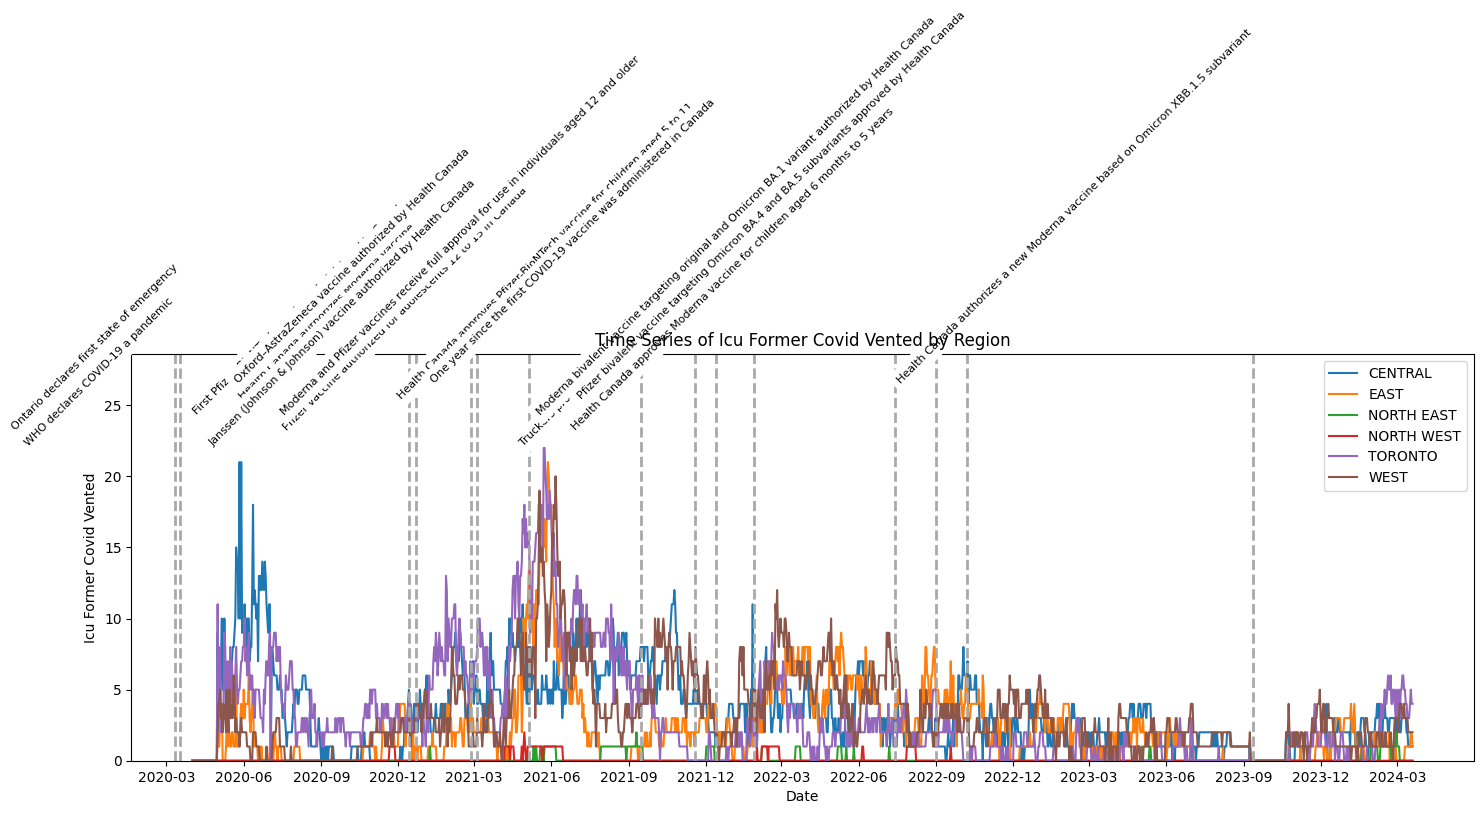

In [34]:
# Key dates
key_dates = {
    '2020-03-11': 'WHO declares COVID-19 a pandemic',
    '2020-03-17': 'Ontario declares first state of emergency',
    '2020-12-14': 'First Pfizer–BioNTech vaccine administered in Canada',
    '2020-12-23': 'Health Canada authorizes Moderna vaccine',
    '2021-02-26': 'Oxford–AstraZeneca vaccine authorized by Health Canada',
    '2021-03-05': 'Janssen (Johnson & Johnson) vaccine authorized by Health Canada',
    '2021-05-05': 'Pfizer vaccine authorized for adolescents 12 to 15 in Canada',
    '2021-09-16': 'Moderna and Pfizer vaccines receive full approval for use in individuals aged 12 and older',
    '2021-11-19': 'Health Canada approves Pfizer-BioNTech vaccine for children aged 5 to 11',
    '2021-12-14': 'One year since the first COVID-19 vaccine was administered in Canada',
    '2022-01-28': 'Truckers protest in Ottawa against mandatory vaccination',
    '2022-07-14': 'Health Canada approves Moderna vaccine for children aged 6 months to 5 years',
    '2022-09-01': 'Moderna bivalent vaccine targeting original and Omicron BA.1 variant authorized by Health Canada',
    '2022-10-07': 'Pfizer bivalent vaccine targeting Omicron BA.4 and BA.5 subvariants approved by Health Canada',
    '2023-09-12': 'Health Canada authorizes a new Moderna vaccine based on Omicron XBB.1.5 subvariant',
}



# Loop over each variable
for field in integer_columns:
    plt.figure(figsize=(15, 8))  # Wider figure for more space
    
    # Plot data for each region
    for region in regions:
        region_data = df[df['oh_region'] == region]
        plt.plot(region_data['date'], region_data[field], label=region)

    # Find the maximum y value for current field to set y limit and position annotations
    y_max = df[field].max()
    plt.ylim(0, y_max * 1.3)  # Increase y-axis limit to create space for annotations

    # Annotate key dates
    for i, (key_date, event) in enumerate(key_dates.items()):
        date = pd.to_datetime(key_date)
        y_pos = y_max * (1 + (i % 5) * 0.05)  # Stagger annotations
        plt.axvline(x=date, color='darkgrey', linestyle='--', linewidth=2)
        plt.text(date, y_pos, event, rotation=45, ha='right', va='bottom', fontsize=8, backgroundcolor='white')

    # Formatting the plot
    plt.title(f"Time Series of {field.replace('_', ' ').title()} by Region")
    plt.xlabel("Date")
    plt.ylabel(field.replace('_', ' ').title())
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.legend()
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()


## Misc Visualizations

<Axes: >

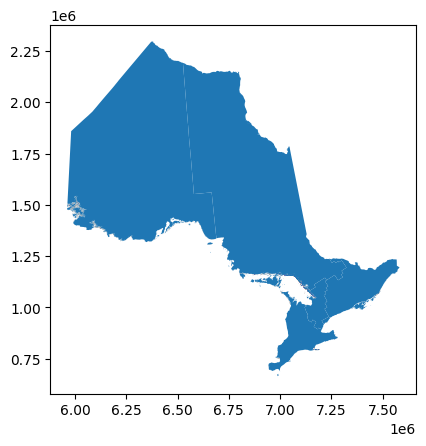

In [3]:
# Load the shapefile
gdf = gpd.read_file('data/ontario_health_region_boundaries.shp')

# Now 'gdf' is a GeoDataFrame that contains the geometry information along with any other attributes
gdf.plot()

In [4]:
gdf.head()

,OBJECTID,OH_Region_,OH_Name,OH_Name_FR,geometry
0,1,01,West,Ouest,"MULTIPOLYGON (((6988892.426 659741.309, 698890..."
1,10,04,East,Est,"MULTIPOLYGON (((7298417.620 974718.909, 729841..."
2,13,05,North East,Nord-Est,"MULTIPOLYGON (((7118925.511 1068041.823, 71189..."
3,14,06,North West,Nord-Ouest,"MULTIPOLYGON (((6658939.003 1265492.257, 66589..."
4,18,02,Central,Centre,"MULTIPOLYGON (((7147972.851 1008518.286, 71479..."


In [5]:
gdf.dtypes

OBJECTID         int64
OH_Region_      object
OH_Name         object
OH_Name_FR      object
geometry      geometry
dtype: object

Text(0, 0.5, 'Frequency')

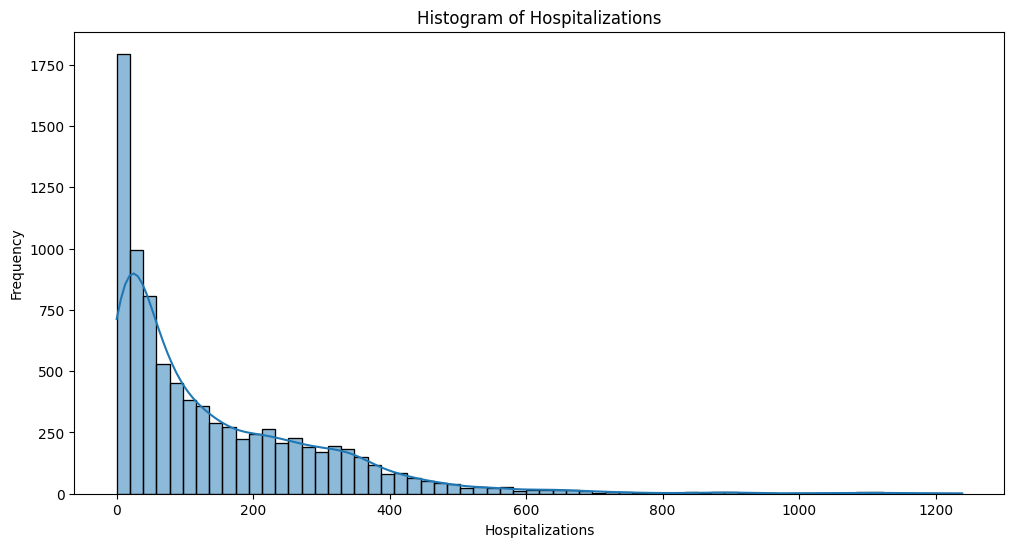

In [6]:
plt.figure(figsize=(12, 6))
sns.histplot(df['hospitalizations'], kde=True)
plt.title('Histogram of Hospitalizations')
plt.xlabel('Hospitalizations')
plt.ylabel('Frequency')

Text(0, 0.5, 'ICU CRCI Total')

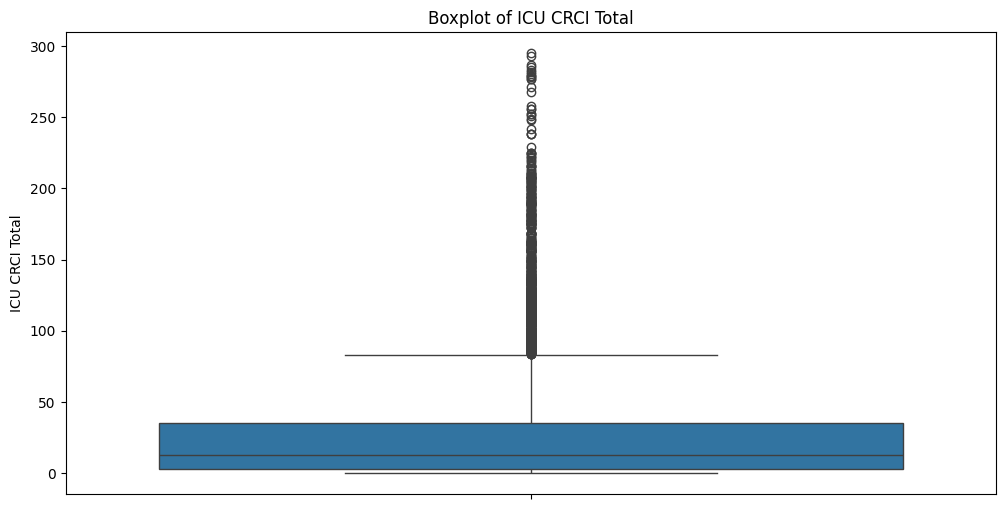

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=df['icu_crci_total'])
plt.title('Boxplot of ICU CRCI Total')
plt.ylabel('ICU CRCI Total')

Text(0, 0.5, 'Cumulative Probability')

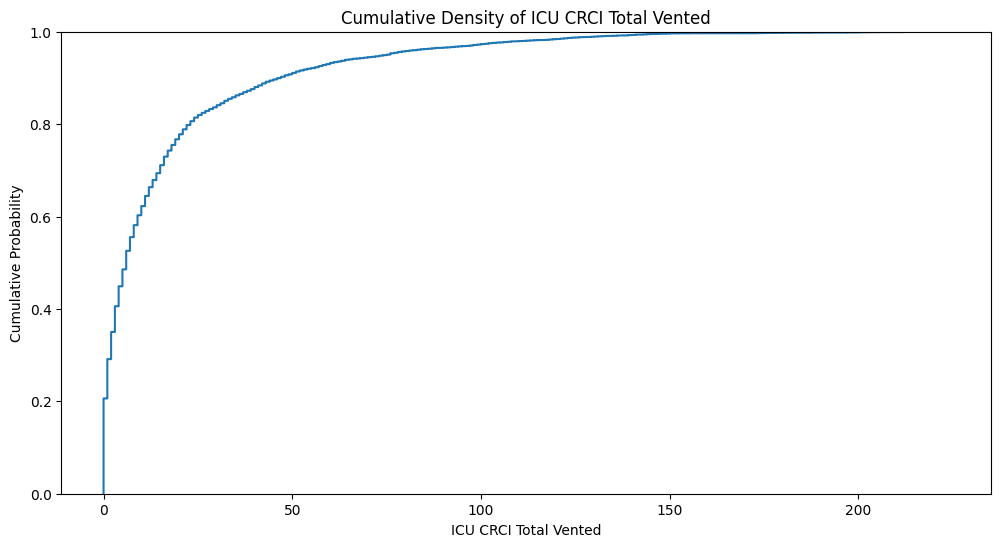

In [8]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(df['icu_crci_total_vented'])
plt.title('Cumulative Density of ICU CRCI Total Vented')
plt.xlabel('ICU CRCI Total Vented')
plt.ylabel('Cumulative Probability')

## Conclusion